In [1]:
from langchain_tavily import TavilySearch
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from dotenv import load_dotenv
import openai
import json
import os

## Loading LLM model

In [2]:
load_dotenv()
llm_model = os.getenv("LLM_MODEL")
print("LLM Model:", llm_model)
llm = init_chat_model(llm_model)
# creating a tool instance for web search using Tavily
tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

LLM Model: openai:gpt-5-mini


## Implementing required classes for basic chat/search functionality and node class for the same

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    try:
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    except openai.RateLimitError as e:
        print("OpenAI API quota exceeded. Please check your plan and billing details.")
        print(f"Error details: {e}")
        return {"messages": []}
    
class BasicChatNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    

## Implementing routing tool

In [4]:
def route_tools(state: State,):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

## create a graphbuilder

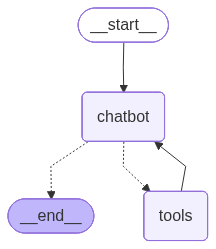

In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = BasicChatNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
def stream_graph_updates(user_input: str):
    try:
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
            for value in event.values():
                print("\nAssistant : ", value["messages"][-1].content)
    except openai.RateLimitError as e:
        print("OpenAI API quota exceeded. Please check your plan and billing details.")
        print(f"Error details: {e}")

stream_graph_updates("what's new with AI tools in cyber security?")

# while True:
#     user_input = input("\nUser: ")
#     if user_input.lower() in ["exit", "quit"]:
#         print("Exiting the chat. Goodbye!")
#         break
    # stream_graph_updates(user_input)


Assistant :  Short answer
AI is moving from narrow ML features (anomaly scoring, signatureless detection) to large‑model and generative capabilities that change both offense and defense. New capabilities are showing up across SOC tooling, devsecops, red‑team automation and threat intelligence — and they bring new attack surfaces and governance needs.

What’s new / the big trends
- LLMs in the SOC: Security platforms now embed large language models to do alert triage, auto‑write playbooks, summarize incidents, generate investigation queries, and draft response actions. This speeds analysts but creates new trust and data‑leakage risks.
- Generative AI as both tool and weapon: Defenders use generative models to synthesize phishing templates, create test malware, and generate remediation code; attackers use them to craft convincing phishing, automate social engineering, and write polymorphic malware.
- Transformer/self‑supervised models for telemetry: New detection models use transformers